In [1]:
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from tqdm import trange
from unidecode import unidecode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
sos_token = 0
eos_token = 1

class Lang:
    def __init__(self, name: str):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def add_sentence(self, sentence: str) -> None:
        for word in sentence.split(" "):
            self.add_word(word)

    def add_word(self, word: str) -> None:
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
def normalize_string(s: str) -> str:
    s = unidecode(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

def read_langs(lang1: str, lang2: str, reverse=False):
    with open("pol.txt", encoding="utf-8") as f:
        lines = f.read().strip().split("\n")

    pairs = [[normalize_string(s) for s in l.split("\t")[:2]] for l in lines]
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [4]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_pairs(pairs):
    return [
        pair for pair in pairs if
        len(pair[0].split(" ")) < MAX_LENGTH and \
        len(pair[1].split(" ")) < MAX_LENGTH and \
        pair[1].startswith(eng_prefixes)
    ]

In [5]:
def prepare_data(lang1: str, lang2: str, reverse: bool = False):
    input_lang, output_lang, pairs = read_langs(lang1, lang2, reverse)

    print(len(pairs))
    pairs = filter_pairs(pairs)
    print(len(pairs))

    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])

    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs 


input_lang, output_lang, pairs  = prepare_data('eng', 'pol', True)
print(random.choice(pairs))

51799
3744
pol 3190
eng 2007
['ona jest prawie tak wysoka jak ja', 'she is about as tall as me']


In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.drop = nn.Dropout(0.1)

    def forward(self, input):
        embedded = self.drop(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size: int, output_size: int):
        super(DecoderRNN, self).__init__()
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.full((batch_size, 1), sos_token, dtype=torch.long, device=device)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None


In [7]:
def indexes_from_sentence(lang: Lang, sentence: str) -> list[int]:
    return [lang.word2index[word] for word in sentence.split(" ")]

def get_dataloader(batch_size: int):
    input_lang, output_lang, pairs = prepare_data("eng", "pol", True)
    
    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexes_from_sentence(input_lang, inp)
        tgt_ids = indexes_from_sentence(output_lang, tgt)

        inp_ids.append(eos_token)
        tgt_ids.append(eos_token)

        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device), torch.LongTensor(target_ids).to(device))
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader


In [8]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

lr = 0.001
nepochs = 200 

losses = []

encoder_opt = optim.Adam(encoder.parameters(), lr)
decoder_opt = optim.Adam(decoder.parameters(), lr)
criterion = nn.NLLLoss()

for epoch in (pbar := trange(1, nepochs+1)):
    total_loss = 0.0
    for data in train_dataloader:
        input_tensor, target_tensor = data

        encoder_opt.zero_grad()
        decoder_opt.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_opt.step()
        decoder_opt.step()

        total_loss += loss.item()

    loss = total_loss / len(train_dataloader)

    if epoch % 5 == 0:
        losses.append(loss)
        total_loss = 0.0
        pbar.set_description(f"Epoch {epoch}, loss: {losses[-1]:.4f}")


51799
3744
pol 3190
eng 2007


Epoch 200, loss: 0.0242: 100%|██████████| 200/200 [04:10<00:00,  1.25s/it]


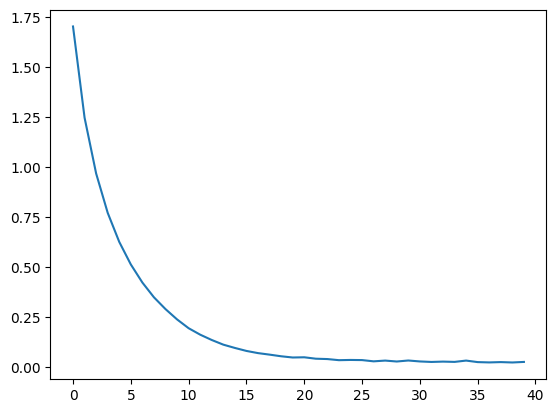

In [9]:
import matplotlib.pyplot as plt


plt.plot(losses)

In [10]:
def tensor_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(eos_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def evaluate_randomly(encoder, decoder, n=10):
    for _ in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])

        decoded_words = []
        with torch.no_grad():
            input_tensor = tensor_from_sentence(input_lang, pair[0])
            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, decoder_hidden, _ = decoder(encoder_outputs, encoder_hidden)

            _, topi = decoder_outputs.topk(1)
            decoded_ids = topi.squeeze()

            for idx in decoded_ids:
                if idx.item() == eos_token:
                    decoded_words.append("<EOS>")
                    break
                decoded_words.append(output_lang.index2word[idx.item()])

        output_sentence = ' '.join(decoded_words)
        print("<", output_sentence)
        print()

encoder.eval()
decoder.eval()
evaluate_randomly(encoder, decoder)

> ona jest sprzedawczynia w supermarkecie
= she is a clerk in the supermarket
< she is a little curious <EOS>

> nie zliczam
= i m not counting
< i m not tom s friend <EOS>

> jestes nieustraszony
= you re fearless
< you re hopeless <EOS>

> zmieniamy to
= we re changing it
< we re sorry in the same class <EOS>

> jest najstarszym synem
= he s the oldest son
< he is two years old <EOS>

> ona jest raczej kiepska w tenisa
= she is rather poor at tennis
< she is rather poor at tennis <EOS>

> ja place
= i m paying
< i m organized tom is <EOS>

> jestem pewien ze tom sie poplacze
= i m positive tom will cry
< i m sure tom will turn up <EOS>

> jestesmy lekarzami
= we are doctors
< we are who and friend <EOS>

> zabije mnie
= she s gonna kill me
< she is mad at me <EOS>

